# 개요

- 제목 
  - 자전거 대여 수요 예측 경진대회
  - 날짜, 계절, 근무일, 날씨, 온도, 체감온도, 풍속 등등 데이터를 활용 자건저 대여 수량을 예측
  - 유형 : 회귀
  - 평가지표 : RMSLE (로그 포함 -> 타겟값의 정규분포화 변환이 필요할듯, 로그 사용)
  - 배경
    - 2014년 5월 ~ 15년 5월까지 1년간 대회 개최
    - 2011년 ~ 2012년 2년간 데이터, 한시간 간격
      - 훈련 데이터 매달 1일 ~ 19일
      - 테스트 데이터 매달 20일 ~ 말일
      - 테스트 데이터 기간 일에 대한 데이터가 훈련에 사용 하지 못하므로 일별 데이터를 생성하더라고 사용 불가
    - 워싱톤 DC의 자건거 무인 대여 시스템의 기록
      - 북반구 -> 확인, 1월이 1로 세팅 되어 있음 (3개월 단위로 계절 세팅)
    - 대여방식
      - 한 장소에서 대여하고, 필요한 만큼 타고, 다른 장소로 반납

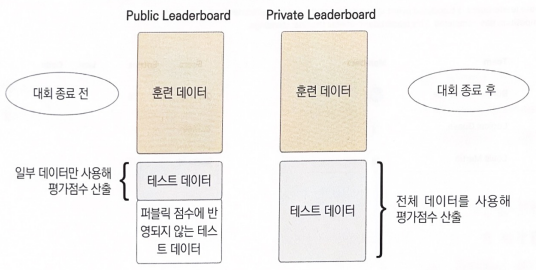

In [1]:
from IPython.display import Image
Image('/content/drive/MyDrive/cloud_ai/share/3.머신러닝/img/ml_캐글평가데이터차이.png')

# 퍼블릭과 프리이빗 점수 차이가 큰경우도 빈번하다(쉐이크업 현상)

# 데이터 준비 (수집, 준비, 분석)

In [2]:
import numpy as np
import pandas as pd

# 데이터 경로
data_path = '/content/drive/MyDrive/cloud_ai/share/3.머신러닝/res/Q3/'

train = pd.read_csv( data_path + 'train.csv')
test  = pd.read_csv( data_path + 'test.csv')
submission = pd.read_csv( data_path + 'sampleSubmission.csv')

In [3]:
train.shape, test.shape, submission.shape

((10886, 12), (6493, 9), (6493, 2))

In [4]:
# train, test 간 피처수가 맞지 않음
print( train.columns )
print( test.columns )
print( submission.columns )
'''
  - 'casual', 'registered', 'count'  3개 피처가 누락(훈련데이터에서)
  - 'count' : 정답이므로 문제 없음
  - 'casual', 'registered' 는 테스트 데이터에 없으므로, 1차적으로 선택은 제거한다(훈련에서 배제한다)
'''

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')
Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')
Index(['datetime', 'count'], dtype='object')


"\n  - 'casual', 'registered', 'count'  3개 피처가 누락(훈련데이터에서)\n  - 'count' : 정답이므로 문제 없음\n  - 'casual', 'registered' 는 테스트 데이터에 없으므로, 1차적으로 선택은 제거한다(훈련에서 배제한다)\n"

In [5]:
'''
  'datetime', : 기록일시, 1시간 단위 => 년, 월, 일 시 분 초 => 요일도 가능(7개로 표현 가능)
                => 시간 단위에 주목 => 분,초는 거의 의미가 없을듯 => 주기성을 가진 
  'season',   : season(봄, 여름, 가을 , 겨울) = 1, 2, 3, 4 => 월3개가 모이면 계절(체크), 순서형 OR 명목형
  'holiday',  : 공휴일( 0, 1 ), 이진형
  'workingday': 일하는날( 0, 1 ), 이진형
  'weather',  : 날씨(1:맑음, 2:약간흐림, 3:약간의 눈/비, 4:폭풍/천둥/번개) = 1, 2, 3, 4, 명목형 (순서가 있을듯 없을듯함)
  'temp',     : 실제온도, 연속형
  'atemp',    : 체감온도, 연속형
  'humidity', : 상대습도, 연속형
  'windspeed' : 풍속, 바람속도, 연속형

  'count'     : 종속변수, 타겟값, 우리가 예측해야할 값, 연속형
'''
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
train.weather.unique()

array([1, 2, 3, 4])

## 결측치 확인

In [7]:
train.info() # 없다

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [8]:
test.info() # 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


## 데이터시각화-EDA

- 데이터의 경향, 차이점 체크
- 필요에 따라서는 시각화 하기 좋은 형태로 값들을 변형 (범주형)
- 시각화를 위해서 부분적인 피처엔지리니어링 진행

### datetime 피처


- 2011-01-01 03:00:00 => 년, 월, 일, 시, 분, 초, weekday(요일)
- 일단 분해해서 파생변수 생성 => EDA후 => 사용여부 체크

In [13]:
from datetime import datetime
import calendar

type( train['datetime'][0] )

print( train['datetime'][0].split()[0], train['datetime'][0].split()[0].split('-')[0] )
print( train['datetime'][0].split()[1], train['datetime'][0].split()[1].split(':')[0] )

2011-01-01 2011
00:00:00 00


In [18]:
# 파생피처, year, month, day, hour, minute, second, weekday(같이진행) 생성
train['year']   = train['datetime'].apply(lambda x: x.split()[0].split('-')[0] )
train['month']  = train['datetime'].apply(lambda x: x.split()[0].split('-')[1] )
train['day']    = train['datetime'].apply(lambda x: x.split()[0].split('-')[2] )
train['hour']   = train['datetime'].apply(lambda x: x.split()[1].split(':')[0] )
train['minute'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[1] )
train['second'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[2] )

train.iloc[:, -7:].head(2)

,count,year,month,day,hour,minute,second
0,16,2011,01,01,00,00,00
1,40,2011,01,01,01,00,00


In [49]:
# weekday
# x.split()[0]
# a = datetime.strptime( x.split()[0], '%Y-%m-%d' ).weekday()
# calendar.day_name[ a ]
train['weekday'] = train['datetime'].apply(lambda x: calendar.day_name[ datetime.strptime( x.split()[0], '%Y-%m-%d' ).weekday() ]  )

In [ ]:
# day, second, minute 필요 없을듯 예상
# month => 3개씩 묶으면 season이 되므로 이부분도 제거 가능 => 대분류 피처로 대변 => 일반적으로 성능이 향상되는 경향이 있다, 제거

### 시각화를 위한 범주형 데이터의 값을 변경 시각화 map()

In [26]:
train['season'].unique()
# 워싱톤의 날씨를 확인해야겟지만 순서대로 배치 1:spring, ...
train['season'] = train['season'].map({
    1:'spring', 2:'summer', 3:'fall', 4:'winter'
})
train['season']

0        spring
1        spring
2        spring
3        spring
4        spring
          ...  
10881    winter
10882    winter
10883    winter
10884    winter
10885    winter
Name: season, Length: 10886, dtype: object

In [27]:
train['weather'].unique()

array([1, 2, 3, 4])

In [28]:
train['weather'] = train['weather'].map({
    1:'good', 2:'week_blur', 3:'week_snow_rain_th', 4:'strong_snow_rain_th'
})
train['weather']

0        good
1        good
2        good
3        good
4        good
         ... 
10881    good
10882    good
10883    good
10884    good
10885    good
Name: weather, Length: 10886, dtype: object

### EDA를 통한 분석

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### **타겟데이터 분포도 확인(중요!!)**

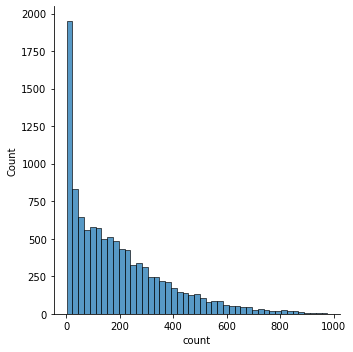

In [32]:
# count 피처 
sns.displot( train['count'] );

- 해석
  - x축 카운트값, y축은 카운트 값의 총개수(빈도)
  - 왼쪽에 몰려 있다(쏠려 있다), 편향되어 있다. 0 주변에 몰려있다
  - **좋음 모델을 만들기 위해서는 데이터가 정규분포를 따르게 만드는게 중요함** => **데이터 분포를 정규분포에 근접하도록 변환 처리**
    - 왼쪽으로 편향된 데이터 => 로그변환 => 정규분포에 가깝게 변환

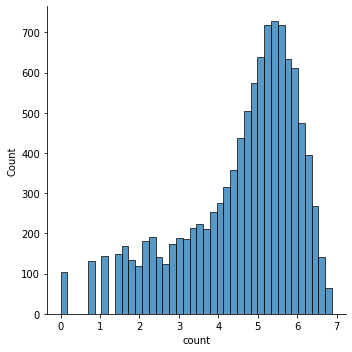

In [33]:
sns.displot( np.log( train['count'] ) );
# 정규분포에 많이 유사하게 변화 처리 했다 (무난하게)
# 정답은 로그 변환한 값으로 학습, 실제 예측을 하면 => 로그처리된값 => 복원 => np.exp() => submission 처리

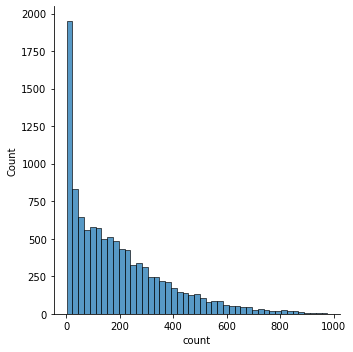

In [34]:
# 원복 확인
sns.displot( np.exp( np.log( train['count'] ) ) );

#### 년, 월, 일, 시, 분, 초 평균 대여 수량을 바차트로 시각화

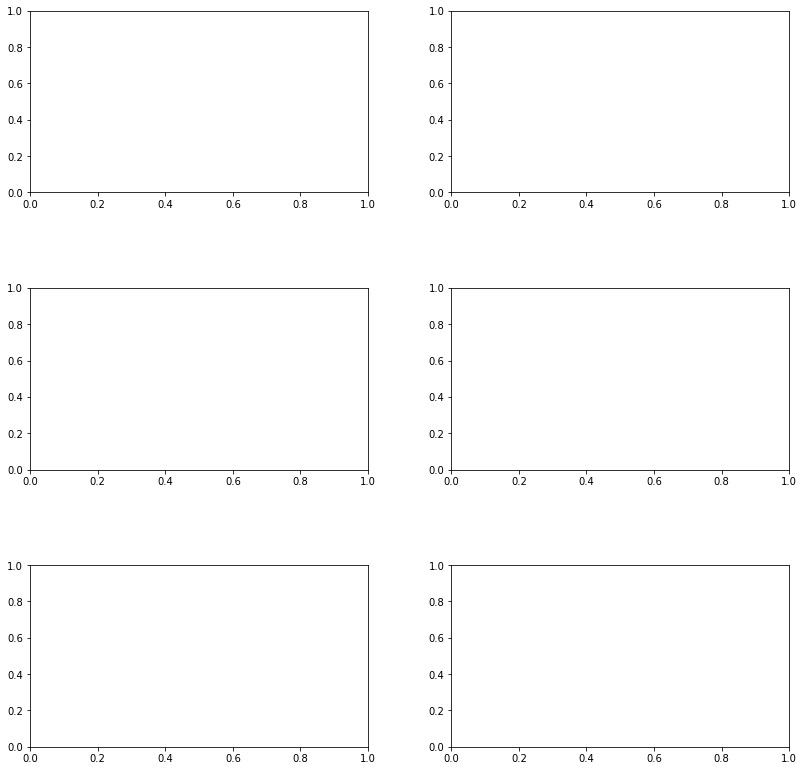

In [37]:
# 3줄, 2칸 행렬형태로 차트 준비
fig, axes = plt.subplots( nrows=3, ncols=2 )
plt.tight_layout() # 여백 확보 
fig.set_size_inches(12,12) #전체 크기 조정 (인치단위)

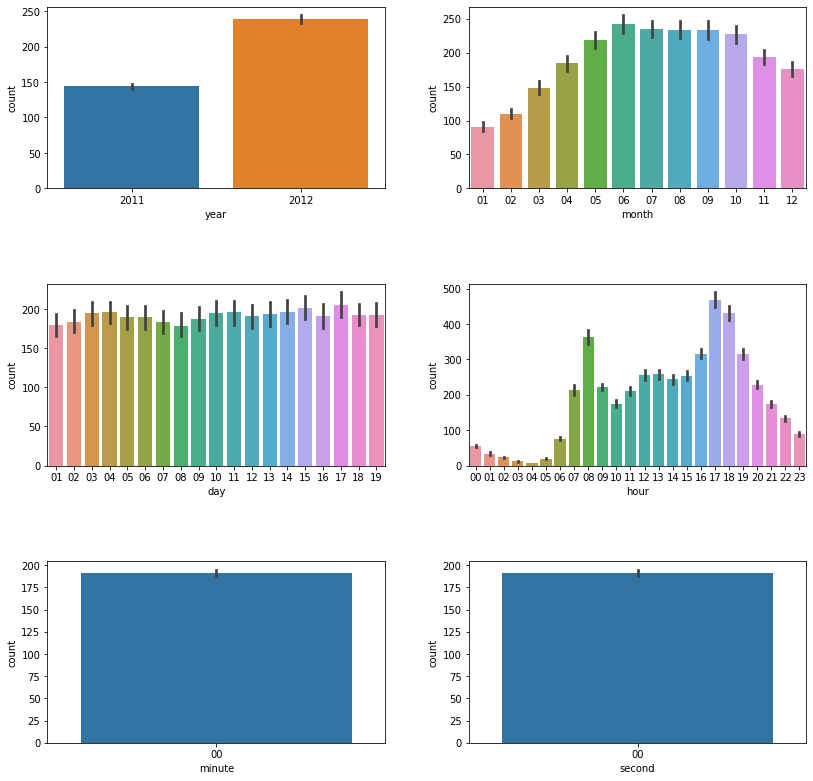

In [39]:
fig, axes = plt.subplots( nrows=3, ncols=2 )
plt.tight_layout()
fig.set_size_inches(12,12)

# 바차트
sns.barplot(x='year', y='count', data=train, ax=axes[0, 0])
sns.barplot(x='month', y='count', data=train, ax=axes[0, 1])
sns.barplot(x='day', y='count', data=train, ax=axes[1, 0])
sns.barplot(x='hour', y='count', data=train, ax=axes[1, 1])
sns.barplot(x='minute', y='count', data=train, ax=axes[2, 0])
sns.barplot(x='second', y='count', data=train, ax=axes[2, 1])

'''
  - 해석
  - minute, second은 값이 오직 00 이고, 무의미하다 - 제거 확정
  - year : 2012도가 대여수가 더 많다. 오차범위도 문제 없음 - 사용
  - month : 비도 차이는 잘 보임 , 최고값들 6월이 피크이고, 10월까지 사용량이 높다, 1~3월에는 사용량이 적은게 확연하다 
           - season이 대분류 성격의 피처라서 일단 제거를 컨셉 
  - day : 20일 이후는 데이터는 학습불가해서 제거,  day간에도 큰 변별력이 없고, 오차범위가 다른 바를 침범할 정도 수준이여서 제거
  - hour : 시간대별로 대부분 사용량이 차이가 난다. 오차 범위도 문제없은 정도로 유지하고 있다 -> 사용
           - 출근시간대 (7~8시) 주변 시간대에 비해 피크값이 나온다
           - 퇴근시간대 (17~18시)에서 피크 사용량이 나온다
           - 사용
'''
plt.show()

#### 근무일, 휴일, 계절, 날씨

- 박스플롯
- 범주형 데이터(x축)에 따른 수치형 데이터(y축) 정보 표현

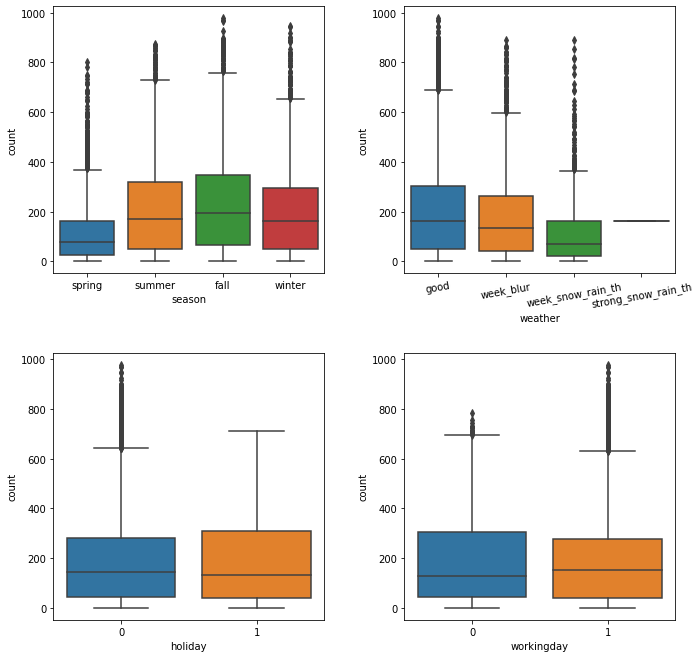

In [42]:
# 2줄에 2칸
fig, axes = plt.subplots( nrows=2, ncols=2 )
plt.tight_layout()
fig.set_size_inches(10,10)

# 바차트
sns.boxplot(x='season',     y='count', data=train, ax=axes[0, 0])
sns.boxplot(x='weather',    y='count', data=train, ax=axes[0, 1])
sns.boxplot(x='holiday',    y='count', data=train, ax=axes[1, 0])
sns.boxplot(x='workingday', y='count', data=train, ax=axes[1, 1])

# 회전
axes[0, 1].tick_params('x', labelrotation=10)

'''
  - 해석
  - season: 계절별 차이가 보임, 봄이 가장 낮다(1,2,3월 봄으로 봤기 때문), 보류
  - weather: 폭풍우(강한번개,천둥,눈폭풍) 치는날 거의 없다, 날씨가 나빠질수록 사용량이 줄어든다
    단 이상치들 때문에 전체 분포상으로 비슷해 보이지만(대분류단위로 묶다 보니 나오는 증상)
  - holiday: 중앙값은 비슷, 휴일아닐때 이상치가 많다 => 변별력이 잘 않보임 (제거할수도 있겟다) 
  - workingday: 중앙값은 비슷, 근무일일때 이상치가 많다 => 변별력이 잘 않보임 (제거할수도 있겟다)   
'''

plt.show()

#### 포인트 플롯을 통한 시각화

- 범주형 데이터 대비 수치형 데이터의 평균과 신뢰구간을 점과선으로 표현
- x축:시간, y축:카운트(정답), hue=워킹데이(일한날):이부분만교체해서 확인 가능

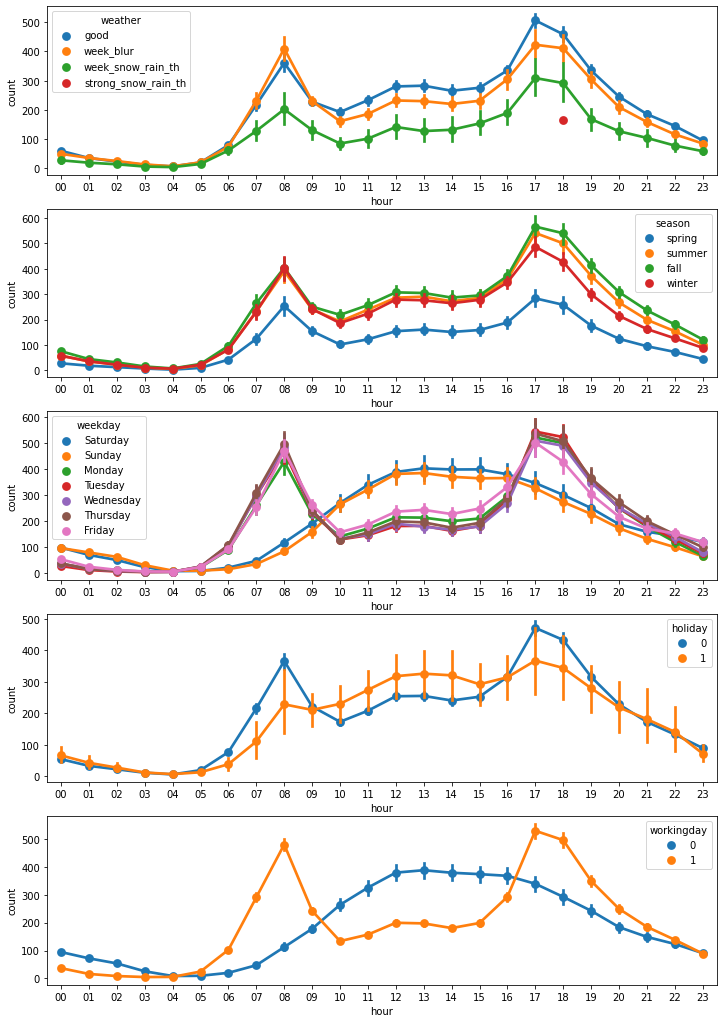

In [52]:
fig, axes = plt.subplots( nrows=5 )
#plt.tight_layout()
fig.set_size_inches(12,18)

'''
  해석 
  - workingday : 일하는날(1) 출 퇴근시 대여 수량이 엄청 증가한다, 쉬는날(0) 12~15까지 대량이 더 높다
                 - 각 포인트의 신뢰구간(포인트별수직바)이 짧기 때문에 신뢰성이 높은(비교적 정확한) 데이터로 보인다\
  - holiday : 1값으로 분류된 포인트들이 신뢰구간이 0번 값 포인트에 많이 침범하고 있다(신뢰성 저하) 학습에 도움이 않될듯
  - weekday : 주 5일근무 기준 월 ~ 금요일은 워킹데이 1값와 유사, 토-일은 워킹데이 0과 유사
                - 대체적으로 사용하는데 무리는 없을듯 다만 (workingday와 상관관계가 있을수도 있을듯)
  - season : 계절 단위로 살펴보면, weekday(주 5일근무),workingday(1) 과 비슷한 추세를 보인다
               - fall, summer, winter 이계절은 거의 비슷하게 움직이고, 신뢰구간도 겹쳐져 잇어서 변별력이 조금 떨어진
  - weather : 가장 날씨가 않좋았을때 18시 부근만 데이터아 존재한다 => 이상치 제거  (값이 4는 제거)           
'''
sns.pointplot( x='hour', y='count', data=train, hue='workingday', ax=axes[4])
sns.pointplot( x='hour', y='count', data=train, hue='holiday', ax=axes[3])
sns.pointplot( x='hour', y='count', data=train, hue='weekday', ax=axes[2])
sns.pointplot( x='hour', y='count', data=train, hue='season', ax=axes[1])
sns.pointplot( x='hour', y='count', data=train, hue='weather', ax=axes[0])

#### 연속형 데이터 시각화(산점도 or 산포도, 회귀선)

- 회귀선을 포함한 산점도 그래프 : regplot
- 데이터간의 상관관계 확인 가능
- 온도, 체감온도, 습도, 풍속

In [58]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'minute', 'second', 'weekday'],
      dtype='object')

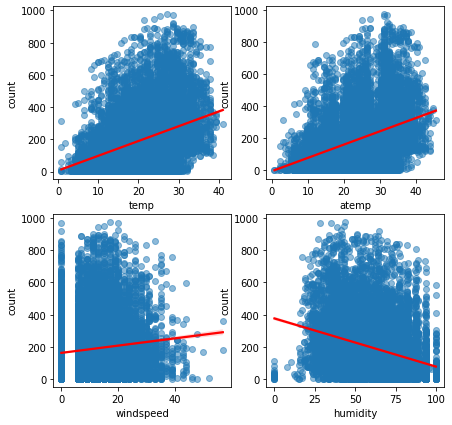

In [59]:
fig, axes = plt.subplots( nrows=2, ncols=2 )
#plt.tight_layout()
fig.set_size_inches(7,7)

sns.regplot( x='temp', y='count', data=train, ax=axes[0,0], line_kws={'color':'red'}, scatter_kws={'alpha':0.5} )
sns.regplot( x='atemp', y='count', data=train, ax=axes[0,1], line_kws={'color':'red'}, scatter_kws={'alpha':0.5} )
sns.regplot( x='windspeed', y='count', data=train, ax=axes[1,0], line_kws={'color':'red'}, scatter_kws={'alpha':0.5} )
sns.regplot( x='humidity', y='count', data=train, ax=axes[1,1], line_kws={'color':'red'}, scatter_kws={'alpha':0.5} )
'''
  해석 
  - 온도, 체감온도는 추세가 유사, 온도가 높을수록 사용량도 증가 (비례적) : 사용가능, 단 둘사이가 비슷(상관관계 체크)
  - 풍속 : 바람이 쎌수록 대량이 늘어난다 (대체적으로, 기울기가 낮음)
    - 0에 데이터가 많다, 단절된 구간도 존재 => 장비 불량으로 인한 오류 => 데이터 자체의 하자 => 피처 제거
  - 습도 : 반비례적으로 습도가 높으면 대여량이 줄어든다
'''
plt.show()

#### 수치형 데이터간 상관관계 체크

- 히트맵
- 강한 상관관계가 있다면 VIF 문제 발생(다중공선성 문제 발생), 신뢰성 저하 => 중요한 피처 1개만 사용

In [61]:
corr_values = train[ ['temp','atemp', 'windspeed', 'humidity', 'count'] ].corr()
corr_values

,temp,atemp,windspeed,humidity,count
temp,1.000000,0.984948,-0.017852,-0.064949,0.394454
atemp,0.984948,1.000000,-0.057473,-0.043536,0.389784
windspeed,-0.017852,-0.057473,1.000000,-0.318607,0.101369
humidity,-0.064949,-0.043536,-0.318607,1.000000,-0.317371
count,0.394454,0.389784,0.101369,-0.317371,1.000000


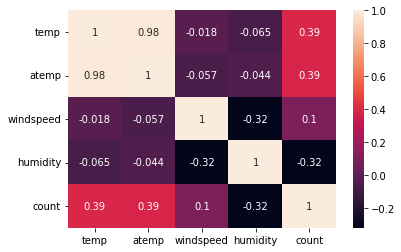

In [63]:
sns.heatmap( corr_values, annot=True );
# temp, atemp는 강한 상관관계 기준 0.9를 초과했다=> 하나만 간다 (피처간 상관관계)
# temp(or atemp)과 count간의 0.39, 약한 양의 상관관계
# 습도과 count간의 -0.32, 약한 음의 상관관계

## EDA 결과

- 피처제거
  - day 컬럼이 파생변수로 생성된다면(컬럼중에 년월일시분초 컬럼이 있었다->쪼개서 파생변수를 만들 가능성이 크다)  미사용 (테스트데이터가 20~말일, 학습시 해당 일에 대한 훈련 불가)
  - train과 test간에 컬럼 불일치
    - 'casual', 'registered' 제거(혹은 미사용)
  - day, month, minute, second
  - temp, atemp 둘중 하나를 제거 하는 조합, 둘다 사용해보는 조합(결과론)
  - windspeed 제거

- 타겟데이터
  - np.log() 처리 하여 학습
  - 테스트데이터 예측값  => np.exp() => submission 처리

- 이상치 제거
  - weather : 가장 날씨가 않좋았을때 18시 부근만 데이터가 존재한다 => 이상치 제거  (값이 4는 제거)   

- 피처 스케일링
  - 결과보고 판단

# 베이스라인 구축 및 모델 구축

- 데이터를 새로 올려서 깨끗 하게 진행

## 피처 엔지니어링

In [82]:
train = pd.read_csv( data_path + 'train.csv')
test  = pd.read_csv( data_path + 'test.csv')
submission = pd.read_csv( data_path + 'sampleSubmission.csv')

train.shape, test.shape, submission.shape

((10886, 12), (6493, 9), (6493, 2))

### 이상치 제거

- weather의 값 4에 대해 훈련용은 이상치로 보이나, 테스트용은 알수 없다(훈련용에서만 제거 해 본다, 체크)

In [83]:
# train에서 weather의 값 4인 데이터 제거
train = train[ train['weather'] != 4 ]
train.shape   # 데이터 1개 제거 되었다

(10885, 12)

### 피처스케일링 및 데이터 합치기

- 훈련용와 테스트용 데이터를 병합해서, 피처 엔지니어링 처리후 다시 분리 처리

In [84]:
train.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16


In [85]:
test.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027


In [86]:
train_test = pd.concat( [train, test], ignore_index=True)
train_test.shape

(17378, 12)

### 파생 피처 생성

- 년도, 시간 정보만 생성
- 파생 변수를 만들면서 문자=> 수치로 대체(인코딩 처리 바로 진행)

In [91]:
train_test['year']    = train_test['datetime'].apply(lambda x: 0 if '2011' == x.split()[0].split('-')[0] else 1 )
train_test['hour']    = train_test['datetime'].apply(lambda x: int(x.split()[1].split(':')[0]) )
train_test['weekday'] = train_test['datetime'].apply(lambda x: datetime.strptime( x.split()[0], '%Y-%m-%d' ).weekday() )
train_test.shape

(17378, 15)

In [92]:
train_test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0,0,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0,0,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0,0,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0,0,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,1,19,0
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,1,20,0
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN,1,21,0
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN,1,22,0


### 피처 제거(or 선택)


- STEP 1. EDA를 통해서 제거 대상 선택
- STEP 2. 다중회귀
  - **후진 제거법**
    - 뒤에 있는 컬럼부터 제거하면서, 학습->예측->펑가 반복
  - **전진 선택법**
    - 앞에 잇는 컬럼부터 선택하면서, 학습->예측->펑가 반복
  - 이런 조합을 통해 가장 좋은 결과가 나온 피처를 선택
  - **피처의 순서**도 영향을 미친다
- STEP 3. 학습중
  - L1 규제를 통해서 회귀계수를 0으로 만들어 피처를 제거(학습단계에처리)

In [93]:
# 'atemp'는 성능여하에 따라 추가할수 도 있다 (성능 올리기 위해서)
feats_drop = ['casual', 'registered', 'datetime', 'windspeed', 'atemp']  
train_test = train_test.drop( feats_drop, axis=1 )
train_test.info()

# 카운트는 훈련용과 테스트용(제출용) 분리시 결측처리가 된다
# 나중에 추가한 파생변수들이 문자열이다 => 수치화 필요
# year 컨셉 (2011, 2012), hour(00~23), weekday(1~7 or 0~6) => 인코딩처리 필요 => 파생변수 생성시 완료 
# 전체 데이터는 모두 수치형으로 변환 완료

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17378 entries, 0 to 17377
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17378 non-null  int64  
 1   holiday     17378 non-null  int64  
 2   workingday  17378 non-null  int64  
 3   weather     17378 non-null  int64  
 4   temp        17378 non-null  float64
 5   humidity    17378 non-null  int64  
 6   count       10885 non-null  float64
 7   year        17378 non-null  int64  
 8   hour        17378 non-null  int64  
 9   weekday     17378 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.3 MB


### 데이터 나누기

- 훈련 데이터 개수를 알고 있으므로, 슬라이싱 처리 가능
- 정답 데이터의 결측 여부로 분리해도 된다

In [95]:
# 정답의 결측 여부로 해결
X_sub = train_test[ pd.isnull( train_test['count'] ) ]  # submission용
# 훈련용
X = train_test[ ~pd.isnull( train_test['count'] ) ]
X.shape, X_sub.shape

((10885, 10), (6493, 10))

In [96]:
X.head(2)
# 정답을 제거해서 y로 추출 별로 체크

,season,holiday,workingday,weather,temp,humidity,count,year,hour,weekday
0,1,0,0,1,9.84,81,16.0,0,0,5
1,1,0,0,1,9.02,80,40.0,0,1,5


In [98]:
# 단, drop등의 행위로 코드를 이어가면, 주소를 가르키고 있는 변수들이 다른 대상을 가르키면서 메모리가 누수가 발생한다
# 차후 del로 삭제하고, gc로 메모리를 확보해 주는게 좋다(딥러닝때 사용)
y = X['count']
X = X.drop( ['count'], axis=1 )
X_sub = X_sub.drop( ['count'], axis=1 )

In [99]:
X.shape, X_sub.shape, y.shape

((10885, 9), (6493, 9), (10885,))

In [100]:
# 훈련용, 테스트용 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8163, 9), (2722, 9), (8163,), (2722,))

## 평가 지표 검점 및 필요시 함수 생성

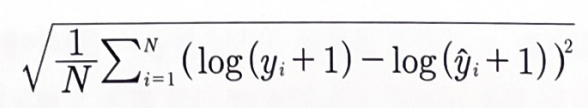

In [103]:
from IPython.display import Image
Image('ml_rmsle_식.png')

In [107]:
from sklearn.metrics import mean_squared_log_error
'''
  - 여러가지 조치 사항들을 적용해야 하므로 평가 함수를 커스텀으로 구성하겠다
  - 차후, 교차 검증시 커스텀 함수는 문구가 없으므로(neg_) 이것도 생성해서 scoring에 세팅한다
'''
import numpy as np

def my_rmsle( y_true, y_pred, transfer=True ):
  '''
    transfer : True이면, 앞에 2개 파라미터를 np.exp() 처리해서 복원한다
    np.sqrt( mean_squared_log_error(y_true, y_pred) ) => +1 보정 때문에 직집 구현 처리 했다
  '''
  if transfer:
    y_true = np.exp(y_true)
    y_pred = np.exp(y_pred)
  
  # 로그변환
  # nan_to_num() : 로그 변환후 결측값이 발생하면 0으로 보정 처리
  log_y_true = np.nan_to_num( np.log(y_true+1) )
  log_y_pred = np.nan_to_num( np.log(y_pred+1) )

  # RMSLE 계산  
  return np.sqrt( np.mean( (log_y_true - log_y_pred)**2 ) )

#my_rmsle()

## 베이스 모델 생성-학습-예측-제출까지

In [108]:
from sklearn.linear_model import LinearRegression

# 학습
lr_model = LinearRegression()
log_y    = np.log( y_train )  
lr_model.fit( X_train, log_y )

LinearRegression()

In [109]:
# 모델 성능 체크
y_pred = lr_model.predict( X_test )
# 평가 -> 0에 가까울수록 좋다(손실함수)
my_rmsle( np.log( y_test ), y_pred )

1.0113716342195682

In [111]:
submission.head(2)

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0


In [114]:
# 제출
sub_y_pred = lr_model.predict( X_sub )
# 대여 개수 세팅
submission['count'] = np.exp(sub_y_pred)
submission.to_csv( 'submission.csv', index=False )

# 제출결과 : private score 1.022... 로 나왔음 => 0에 가깝게 가도록 성능향상 진행

- https://www.kaggle.com/c/bike-sharing-demand

# 모델 성능 향상

## 릿지 혹은 라쏘 모델 적용

In [115]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

### 모델 생성, 그리드 서치 + 하이퍼파라미터 튜닝

In [121]:
from sklearn.metrics import make_scorer

lasso_model = Lasso()
param_grid = {
    'max_iter':[1000, 2000, 3000],
    'alpha':1/np.array([0.01, 0.1, 1, 2, 4, 8, 10, 100, 200 ,300])
}
# greater_is_better : Ture 값이 커지는게 좋아지는것, False 낮아지는 것이 좋아지는 것이다(손실함수)
my_rmsle_scorer = make_scorer( my_rmsle, greater_is_better=False)
grid_model      = GridSearchCV(lasso_model, param_grid, scoring=my_rmsle_scorer, cv=5)

# 교차 검증 학습
grid_model.fit( X_train, log_y )

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e+02, 1.00000000e+01, 1.00000000e+00, 5.00000000e-01,
       2.50000000e-01, 1.25000000e-01, 1.00000000e-01, 1.00000000e-02,
       5.00000000e-03, 3.33333333e-03]),
                         'max_iter': [1000, 2000, 3000]},
             scoring=make_scorer(my_rmsle, greater_is_better=False))

### 성능 검증 후 제출

In [122]:
# 최적파라미터
grid_model.best_params_, grid_model.best_score_

({'alpha': 0.01, 'max_iter': 1000}, -1.0262369700250573)

In [123]:
y_pred = grid_model.best_estimator_.predict(X_test)
my_rmsle( np.log( y_test ), y_pred )

1.011443543053433

- 성능 개선이 않된다
  - 피처 성능을 올리거나 아니면 모델을 앙상블 모델로 교체해서 진행
  - 제출 않함

## 앙상블-베깅-랜덤 포레스트 모델 적용

### 하이퍼파라미터 튜닝

In [128]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()
param_grid = {
   'n_estimators' : [100, 120, 140],
   'random_state' : [0, 20, 42]
}
grid_req = GridSearchCV(rf_reg, param_grid, scoring=my_rmsle_scorer, cv=5)
grid_req.fit( X_train, log_y )

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [100, 120, 140],
                         'random_state': [0, 20, 42]},
             scoring=make_scorer(my_rmsle, greater_is_better=False))

In [129]:
# 최적파라미터
grid_req.best_params_, grid_req.best_score_

({'n_estimators': 140, 'random_state': 20}, -0.3219083573166034)

In [131]:
y_pred = grid_req.best_estimator_.predict(X_test)
my_rmsle( np.log( y_test ), y_pred )

0.3156063147438075

### 제출

In [132]:
# 제출
sub_y_pred = grid_req.best_estimator_.predict( X_sub )
# 대여 개수 세팅
submission['count'] = np.exp(sub_y_pred)
submission.to_csv( 'submission_v2.csv', index=False )

# 0.4xxx, 230등 내외로 진입

## 풀데이터 활용


- 전체 훈련용 데이터를 모두 사용하여 진행

In [133]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()
param_grid = {
   'n_estimators' : [100, 120, 140],
   'random_state' : [0, 20, 42]
}
grid_req = GridSearchCV(rf_reg, param_grid, scoring=my_rmsle_scorer, cv=5)
# cv는 진행한 모델 => 차후에 하이퍼파라미터만 챙겨서 직접 훈련 진행 100%데이터를 다 사용할수 있다
grid_req.fit( X, np.log(y) )

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [100, 120, 140],
                         'random_state': [0, 20, 42]},
             scoring=make_scorer(my_rmsle, greater_is_better=False))

In [134]:
# 최적파라미터
grid_req.best_params_, grid_req.best_score_

({'n_estimators': 140, 'random_state': 20}, -0.4611435563447038)

In [135]:
# 제출
sub_y_pred = grid_req.best_estimator_.predict( X_sub )
# 대여 개수 세팅
submission['count'] = np.exp(sub_y_pred)
submission.to_csv( 'submission_v3.csv', index=False )

# 0.39, 160여등위까지 진입

### 학습및 제출

- 경진대회 메달 조건

|--|0~99팀|100~249팀|250~999팀|1000팀 이상|
|--|--|--|--|--|
|금|상위 10%|상위 1위|상위 10위+0.2%|상위 10%+0.2%|
|은|상위 20%|상위 20%|상위 50위|상위 5%|
|동|상위 40%|상위 40%|상위 100위|상위 10%|